In [10]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.ticker import NullFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.optimize import curve_fit
from analysis_measurement import MeasurementAnalyzer

In [2]:
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['axes.titlesize'] = 16
matplotlib.rcParams['legend.fontsize'] = 14

## Cluster Data and Apply Crystal and Module Cuts

In [3]:
file1 = "../data/hdf5_files/measurement.hdf5"
An = MeasurementAnalyzer(file1)
An.apply_crystal_cut(energy_window=[0.01, 1_000])
An.apply_clustering(delta_t_threshold=3.3e3, verbose=True)
An.apply_module_cut(energy_window=[0.01, 1_000], coincidence=True)

0.0
0.08503408591333836
0.17006817182667672
0.2551022577400151
0.34013634365335343
0.4251704295666918
0.5102045154800302
0.5952386013933685
0.6802726873067069
0.7653067732200453
0.8503408591333836
0.935374945046722


## Compute Amount of Back-to-Back Events

In [4]:
data = An.get_cluster_data()
Energies_A = data[:, 1]
Energies_B = data[:, 2]

n_btb = 0
for (E_A, E_B) in zip(Energies_A, Energies_B):
    if E_A > 500 and E_B > 500:
        n_btb += 1

print(f"Number of back-to-back events: {n_btb}")

Number of back-to-back events: 13


## Create Histogram of Group Sizes After Preprocessing

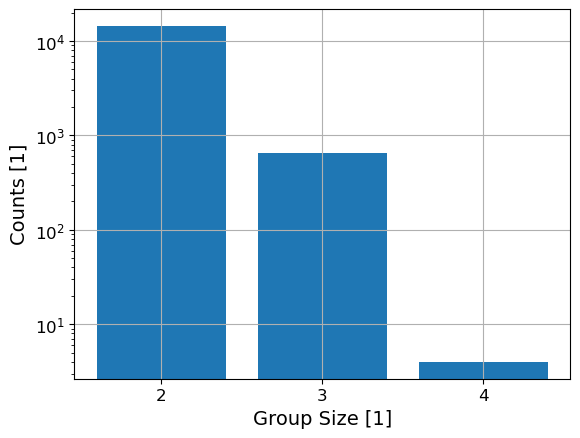

In [5]:
# What is the group size after clustering?
group_sizes = np.array([len(group) for group in An.filtered_groups])
bins, counts = np.unique(group_sizes, return_counts=True)
plt.bar(bins, counts)
plt.xlabel("Group Size [1]")
plt.ylabel("Counts [1]")
plt.grid()
plt.xticks(bins)
plt.yscale('log', base=10)

## Create Time-Energy and Energy A-Energy B Histograms

In [6]:
cluster_data = An.get_cluster_data()
delta_ts = cluster_data[:, 0]
energies_A = cluster_data[:, 1]
energies_B = cluster_data[:, 2]
energies_total = energies_A+energies_B
n_events = len(cluster_data)
print(f'Amount of measured events after clustering and filtering: {n_events}')

Amount of measured events after clustering and filtering: 15120


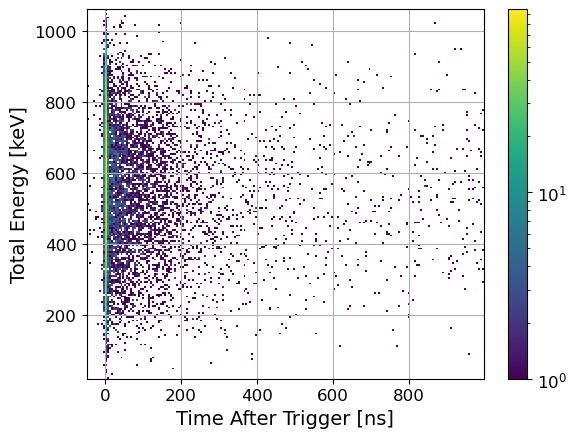

In [7]:
plt.hist2d(1e-3*delta_ts, energies_total, bins=200, norm=LogNorm())
plt.xlabel("Time After Trigger [ns]")
plt.ylabel("Total Energy [keV]")
plt.grid()
plt.colorbar()
plt.show()

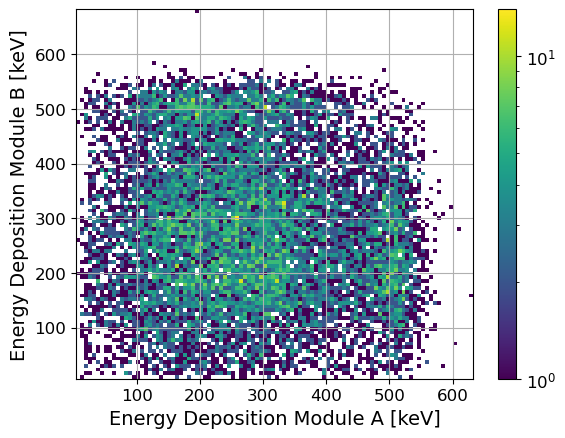

In [8]:
plt.hist2d(energies_A, energies_B, bins=100, norm=LogNorm())
plt.xlabel("Energy Deposition Module A [keV]")
plt.ylabel("Energy Deposition Module B [keV]")
plt.grid()
plt.colorbar()
plt.show()

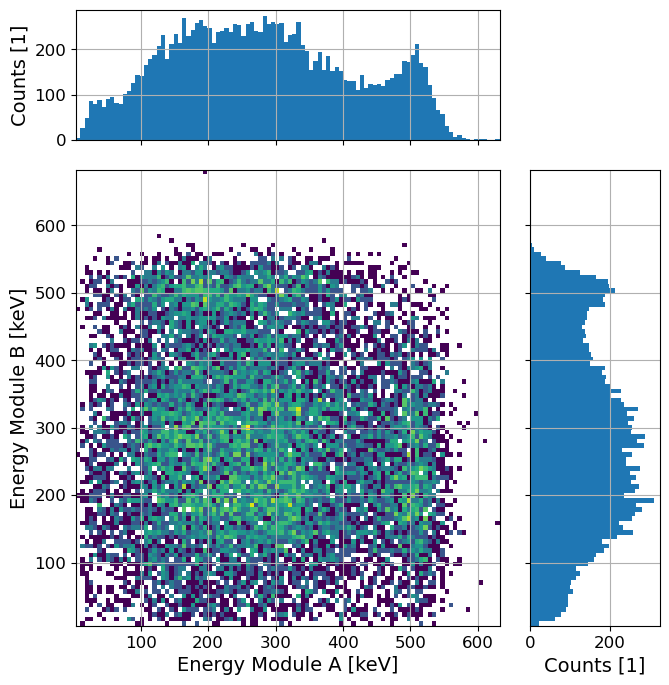

In [11]:
# # Creating fancy histogram
fig, ax2DHist = plt.subplots(figsize=(8, 8))

# Create a divider for the existing axes instance
divider = make_axes_locatable(ax2DHist)

# Append axes to the right and top of the current axis
axHistx = divider.append_axes("top", 1.3, pad=0.3)
axHisty = divider.append_axes("right", 1.3, pad=0.3)

# no labels
nullfmt = NullFormatter()
axHistx.xaxis.set_major_formatter(nullfmt)
axHisty.yaxis.set_major_formatter(nullfmt)

# 2D histogram
hist2d = ax2DHist.hist2d(energies_A, energies_B, bins=(100, 100), cmap='viridis', norm=LogNorm())
ax2DHist.grid()
ax2DHist.set_xlabel('Energy Module A [keV]')
ax2DHist.set_ylabel('Energy Module B [keV]')
ax2DHist.set_aspect('equal', adjustable='box')

# x direction histogram
axHistx.hist(energies_A, bins=100)
axHistx.set_xlim(ax2DHist.get_xlim())
axHistx.set_ylabel('Counts [1]')
axHistx.grid()

# y direction histogram
axHisty.hist(energies_B, bins=100, orientation='horizontal')
axHisty.set_ylim(ax2DHist.get_ylim())
axHisty.set_xlabel('Counts [1]')
axHisty.grid()

plt.show()

## Investigate Time Histogram to Used to Find o-Ps Lifetime

[5.51658482e+01 9.98250336e+04]


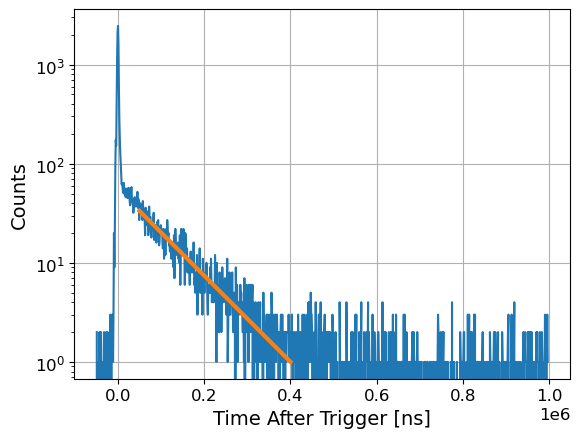

Estimated tau: 99.82503364663299


In [12]:
counts, bins = np.histogram(delta_ts, bins=1_000)
bins = bins[:-1]

def time_to_index(t):
    t0 = bins[0]
    dt = bins[1]-bins[0]
    i = int((t-t0)/dt)
    return i

# fit exponential curve
def exp(t, N, tau):
    return N*np.exp(-t/tau)

p0 = [10**2, 142000]
t_start = 5e4
t_end = 4e5
i_start = time_to_index(t_start)
i_end = time_to_index(t_end)
popt, pcov = curve_fit(exp, bins[i_start:i_end], counts[i_start:i_end], p0)
t_fit = np.linspace(t_start, t_end, 100)

print(popt)
plt.plot(bins, counts)
plt.plot(t_fit, exp(t_fit, *popt), lw=3)
plt.xlabel("Time After Trigger [ns]")
plt.ylabel("Counts")
plt.grid()
plt.yscale('log', base=10)
plt.show();

tau = 1e-3*popt[1]
print(f'Estimated tau: {tau}')

## Investigate Energy Histogram (Where are the 511 Lines?)

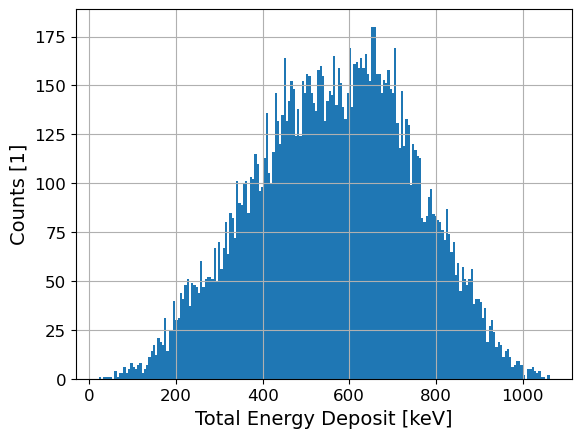

In [13]:
plt.hist(energies_total, bins=200)
plt.xlabel("Total Energy Deposit [keV]")
plt.ylabel("Counts [1]")
plt.grid()

## Create Fance Histogram Again

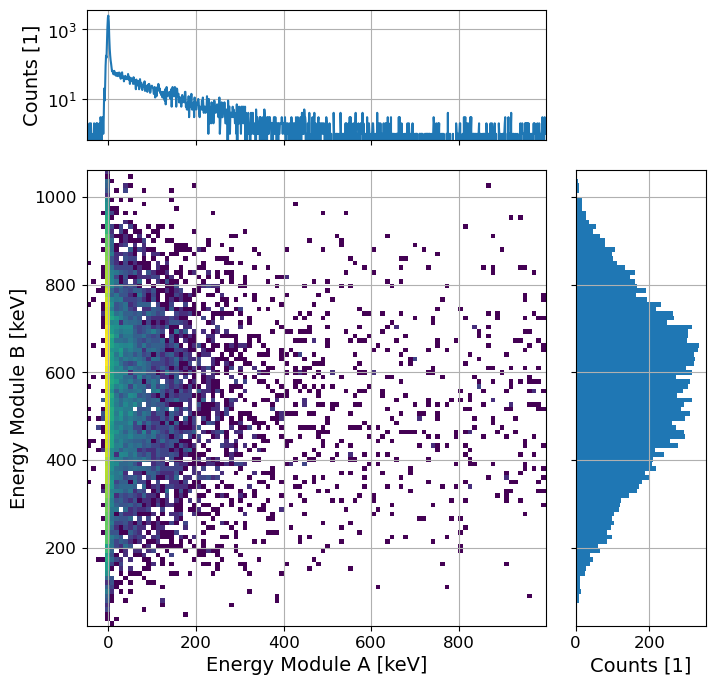

In [14]:
n_filtered_groups = An.n_filtered_groups
n_events = An.n_events_raw

# # Creating fancy histogram
fig, ax2DHist = plt.subplots(figsize=(8, 8))

# Create a divider for the existing axes instance
divider = make_axes_locatable(ax2DHist)

# Append axes to the right and top of the current axis
axHistx = divider.append_axes("top", 1.3, pad=0.3)
axHisty = divider.append_axes("right", 1.3, pad=0.3)

# no labels
nullfmt = NullFormatter()
axHistx.xaxis.set_major_formatter(nullfmt)
axHisty.yaxis.set_major_formatter(nullfmt)

# 2D histogram
hist2d = ax2DHist.hist2d(1e-3*delta_ts, energies_total, bins=(100, 100), cmap='viridis', norm=LogNorm())
ax2DHist.grid()
ax2DHist.set_xlabel('Energy Module A [keV]')
ax2DHist.set_ylabel('Energy Module B [keV]')
ax2DHist.set_aspect('equal', adjustable='box')

# x direction histogram
counts, bins = np.histogram(delta_ts, bins=1000)
# axHistx.hist(1e-3*delta_ts, bins=100)
axHistx.plot(1e-3*bins[:-1], counts)
axHistx.set_yscale('log', base=10)
axHistx.set_xlim(ax2DHist.get_xlim())
axHistx.set_ylabel('Counts [1]')
axHistx.grid()

# y direction histogram
axHisty.hist(energies_total, bins=100, orientation='horizontal')
axHisty.set_ylim(ax2DHist.get_ylim())
axHisty.set_xlabel('Counts [1]')
axHisty.grid()

# Save the figure
filename = '/Users/simonwittum/Documents/Uni/Master/Semester2/SemesterProject/Thesis/img/4_measurements/correlation_plot.png'
# plt.savefig(filename, dpi=300, bbox_inches='tight')

plt.show()